In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph
%pip install -q langchain-google-genai
%pip install -q -U langchain_core langchain-community

## SPAM

In [14]:
import os
import logging
import re
from typing import List
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from pprint import pprint

# ============================================================
# CONFIGURATION AND SETUP
# ============================================================

# Configure the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0
)

# Setup logging for debugging
logging.basicConfig(level=logging.INFO)

# ============================================================
# DATA STRUCTURES
# ============================================================

class State(BaseModel):
    messages: List[str] = Field(default_factory=list, description="List of messages")
    sender: str = Field(..., description="Email sender")
    subject: str = Field(..., description="Email subject")
    body: str = Field(..., description="Email body")
    attachments: List[str] = Field(default_factory=list, description="List of attachment filenames")
    is_whitelisted: bool = Field(False, description="Is sender whitelisted")
    is_blacklisted: bool = Field(False, description="Is sender blacklisted")
    spam_score: float = Field(0.0, description="Spam score of the email")
    is_malicious_attachment: bool = Field(False, description="Are attachments malicious")
    classification: str = Field("", description="Email classification")
    human_decision: str = Field("", description="Decision made by human reviewer")

class EmailContent(BaseModel):
    subject: str
    body: str

class Attachments(BaseModel):
    files: List[str]

# ============================================================
# TOOLS
# ============================================================

@tool(args_schema=EmailContent)
def analyze_spam_score(subject: str, body: str) -> float:
    """
    Analyze the email content to determine its spam score using LLM.
    """
    prompt = (
        f"Analyze the following email for spam likelihood.\n\n"
        f"Subject: {subject}\n"
        f"Body: {body}\n\n"
        "Provide a spam score between 0.0 (not spam) and 1.0 (definitely spam)."
    )
    response = llm.invoke(prompt)
    match = re.search(r"(\d*\.?\d+)", response.content.strip())
    if match:
        return max(0.0, min(float(match.group(1)), 1.0))
    logging.error(f"Invalid response for spam score: {response.content.strip()}")
    return 0.1

@tool(args_schema=Attachments)
def scan_attachments(files: List[str]) -> bool:
    """
    Scan the provided attachments for malicious content using LLM.
    """
    malicious_extensions = [".exe", ".zip", ".rar", ".js"]
    if any(file.lower().endswith(ext) for ext in malicious_extensions for file in files):
        return True

    prompt = (
        f"Analyze the following attachments for malicious content:\n"
        f"{files}\nRespond with 'Yes' or 'No'."
    )
    response = llm.invoke(prompt)
    return "yes" in response.content.lower()

# ============================================================
# GRAPH NODES
# ============================================================

def input_node(state: State) -> State:
    logging.info("Input node initialized.")
    print("\n=== Input Stage ===")
    print("Email loaded with the following details:")
    pprint({
        "Sender": state.sender,
        "Subject": state.subject,
        "Body": state.body,
        "Attachments": state.attachments
    })
    return state

def spam_analysis_node(state: State) -> State:
    logging.info("Starting spam analysis...")
    state.spam_score = analyze_spam_score.run(
        {"subject": state.subject, "body": state.body}
    )
    print("\n=== Spam Analysis Stage ===")
    print(f"Spam score calculated: {state.spam_score}")
    return state

def attachment_scan_node(state: State) -> State:
    logging.info("Scanning attachments for malicious content...")
    state.is_malicious_attachment = scan_attachments.run(
        {"files": state.attachments}
    )
    print("\n=== Attachment Scan Stage ===")
    print(f"Malicious attachment detected: {state.is_malicious_attachment}")
    return state

def human_review_node(state: State) -> State:
    # Pause the execution until the user provides a decision
    print("\n=== Human Review Stage ===")
    print("The email has been flagged for human review based on the following:")
    print(f"- Spam score: {state.spam_score}")
    print(f"- Malicious attachment detected: {state.is_malicious_attachment}")
    while True:
        user_input = input("Do you want to mark this email as SPAM? (y/n): ").strip().lower()
        if user_input == "y":
            state.classification = "spam"
            state.human_decision = "Marked as SPAM by human reviewer."
            break
        elif user_input == "n":
            state.classification = "not_spam"
            state.human_decision = "Marked as NOT SPAM by human reviewer."
            break
        else:
            print("Invalid input. Please respond with 'y' for SPAM or 'n' for NOT SPAM.")

    print("\nHuman decision recorded:")
    pprint({
        "Classification": state.classification,
        "Human Decision": state.human_decision
    })
    return state

def classification_node(state: State) -> State:
    print("\n=== Final Classification Stage ===")
    if state.classification == "not_spam" and (state.spam_score > 0.8 or state.is_malicious_attachment):
        print("Note: The email was originally flagged as SPAM, but the human reviewer marked it as NOT SPAM.")
    else:
        print("This email was classified as NOT SPAM.")

    print(f"Final classification: {state.classification}")
    return state

# ============================================================
# BUILD AND COMPILE GRAPH
# ============================================================

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("input_node", input_node)
graph_builder.add_node("spam_analysis_node", spam_analysis_node)
graph_builder.add_node("attachment_scan_node", attachment_scan_node)
graph_builder.add_node("human_review_node", human_review_node)
graph_builder.add_node("classification_node", classification_node)

# Define edges to establish the sequence of execution
graph_builder.add_edge(START, "input_node")
graph_builder.add_edge("input_node", "spam_analysis_node")
graph_builder.add_edge("spam_analysis_node", "attachment_scan_node")
graph_builder.add_edge("attachment_scan_node", "human_review_node")
graph_builder.add_edge("human_review_node", "classification_node")
graph_builder.add_edge("classification_node", END)

# Compile the graph with an in-memory checkpointer
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    # Initial email state
    state = State(
        sender="unknown@spamsite.com",
        subject="Exclusive Offer: Get Your Free iPhone Now!",
        body=(
            "Dear user,\n\n"
            "We have an exclusive offer for you! Claim your free iPhone by completing the form below. "
            "This is a limited-time offer, so act fast!\n\n"
            "Best regards,\n"
            "Genuine Promotions Team"
        ),
        attachments=["offer_form.pdf"]
    )

    # Configuration with thread_id
    config = {"configurable": {"thread_id": "email_processing_thread"}}

    # Run the graph
    print("\n🚀 Running Email Processing Pipeline...\n")
    for event in graph.stream(state.model_dump(), config=config):
        pass  # We are handling the printing within the nodes

    print("\n✅ Processing complete.")


INFO:root:Input node initialized.
INFO:root:Starting spam analysis...



🚀 Running Email Processing Pipeline...


=== Input Stage ===
Email loaded with the following details:
{'Attachments': ['offer_form.pdf'],
 'Body': 'Dear user,\n'
         '\n'
         'We have an exclusive offer for you! Claim your free iPhone by '
         'completing the form below. This is a limited-time offer, so act '
         'fast!\n'
         '\n'
         'Best regards,\n'
         'Genuine Promotions Team',
 'Sender': 'unknown@spamsite.com',
 'Subject': 'Exclusive Offer: Get Your Free iPhone Now!'}


INFO:root:Scanning attachments for malicious content...



=== Spam Analysis Stage ===
Spam score calculated: 0.9

=== Attachment Scan Stage ===
Malicious attachment detected: False

=== Human Review Stage ===
The email has been flagged for human review based on the following:
- Spam score: 0.9
- Malicious attachment detected: False

Human decision recorded:
{'Classification': 'not_spam',
 'Human Decision': 'Marked as NOT SPAM by human reviewer.'}

=== Final Classification Stage ===
Note: The email was originally flagged as SPAM, but the human reviewer marked it as NOT SPAM.
Final classification: not_spam

✅ Processing complete.


## Non Spam

In [18]:
import os
import logging
import re
from typing import List
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from pprint import pprint

# ============================================================
# CONFIGURATION AND SETUP
# ============================================================

# Configure the LLM
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=os.getenv("GOOGLE_API_KEY"),
    temperature=0
)

# Setup logging for debugging
logging.basicConfig(level=logging.INFO)

# ============================================================
# DATA STRUCTURES
# ============================================================

class State(BaseModel):
    messages: List[str] = Field(default_factory=list, description="List of messages")
    sender: str = Field(..., description="Email sender")
    subject: str = Field(..., description="Email subject")
    body: str = Field(..., description="Email body")
    attachments: List[str] = Field(default_factory=list, description="List of attachment filenames")
    is_whitelisted: bool = Field(False, description="Is sender whitelisted")
    is_blacklisted: bool = Field(False, description="Is sender blacklisted")
    spam_score: float = Field(0.0, description="Spam score of the email")
    is_malicious_attachment: bool = Field(False, description="Are attachments malicious")
    classification: str = Field("", description="Email classification")
    human_decision: str = Field("", description="Decision made by human reviewer")

class EmailContent(BaseModel):
    subject: str
    body: str

class Attachments(BaseModel):
    files: List[str]

# ============================================================
# TOOLS
# ============================================================

@tool(args_schema=EmailContent)
def analyze_spam_score(subject: str, body: str) -> float:
    """
    Analyze the email content to determine its spam score using LLM.
    """
    prompt = (
        f"Analyze the following email for spam likelihood.\n\n"
        f"Subject: {subject}\n"
        f"Body: {body}\n\n"
        "Provide a spam score between 0.0 (not spam) and 1.0 (definitely spam)."
    )
    response = llm.invoke(prompt)
    match = re.search(r"(\d*\.?\d+)", response.content.strip())
    if match:
        return max(0.0, min(float(match.group(1)), 1.0))
    logging.error(f"Invalid response for spam score: {response.content.strip()}")
    return 0.1

@tool(args_schema=Attachments)
def scan_attachments(files: List[str]) -> bool:
    """
    Scan the provided attachments for malicious content using LLM.
    """
    malicious_extensions = [".exe", ".zip", ".rar", ".js"]
    if any(file.lower().endswith(ext) for ext in malicious_extensions for file in files):
        return True

    prompt = (
        f"Analyze the following attachments for malicious content:\n"
        f"{files}\nRespond with 'Yes' or 'No'."
    )
    response = llm.invoke(prompt)
    return "yes" in response.content.lower()

# ============================================================
# GRAPH NODES
# ============================================================

def input_node(state: State) -> State:
    logging.info("Input node initialized.")
    print("\n=== Input Stage ===")
    print("Email loaded with the following details:")
    pprint({
        "Sender": state.sender,
        "Subject": state.subject,
        "Body": state.body,
        "Attachments": state.attachments
    })
    return state

def spam_analysis_node(state: State) -> State:
    logging.info("Starting spam analysis...")
    state.spam_score = analyze_spam_score.run(
        {"subject": state.subject, "body": state.body}
    )
    print("\n=== Spam Analysis Stage ===")
    print(f"Spam score calculated: {state.spam_score}")
    return state

def attachment_scan_node(state: State) -> State:
    logging.info("Scanning attachments for malicious content...")
    state.is_malicious_attachment = scan_attachments.run(
        {"files": state.attachments}
    )
    print("\n=== Attachment Scan Stage ===")
    print(f"Malicious attachment detected: {state.is_malicious_attachment}")
    return state

def human_review_node(state: State) -> State:
    # If the spam score is less than 0.5, automatically classify as not spam and skip human review
    if state.spam_score < 0.5:
        print("\n=== Human Review Stage ===")
        print("Spam score is less than 0.5, automatically classified as NOT SPAM. Skipping human review.")
        state.classification = "not_spam"
        state.human_decision = "No human review needed; classified as NOT SPAM based on low spam score."
        print("\nHuman decision recorded:")
        pprint({
            "Classification": state.classification,
            "Human Decision": state.human_decision
        })
        return state

    # If the spam score is 0.5 or greater, ask for human review
    print("\n=== Human Review Stage ===")
    print("The email has been flagged for human review based on the following:")
    print(f"- Spam score: {state.spam_score}")
    print(f"- Malicious attachment detected: {state.is_malicious_attachment}")
    while True:
        user_input = input("Do you want to mark this email as SPAM? (y/n): ").strip().lower()
        if user_input == "y":
            state.classification = "spam"
            state.human_decision = "Marked as SPAM by human reviewer."
            break
        elif user_input == "n":
            state.classification = "not_spam"
            state.human_decision = "Marked as NOT SPAM by human reviewer."
            break
        else:
            print("Invalid input. Please respond with 'y' for SPAM or 'n' for NOT SPAM.")

    print("\nHuman decision recorded:")
    pprint({
        "Classification": state.classification,
        "Human Decision": state.human_decision
    })
    return state



def classification_node(state: State) -> State:
    print("\n=== Final Classification Stage ===")
    if state.classification == "not_spam" and (state.spam_score > 0.8 or state.is_malicious_attachment):
        print("Note: The email was originally flagged as SPAM, but the human reviewer marked it as NOT SPAM.")
    else:
        print("This email was classified as NOT SPAM.")

    print(f"Final classification: {state.classification}")
    return state

# ============================================================
# BUILD AND COMPILE GRAPH
# ============================================================

graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("input_node", input_node)
graph_builder.add_node("spam_analysis_node", spam_analysis_node)
graph_builder.add_node("attachment_scan_node", attachment_scan_node)
graph_builder.add_node("human_review_node", human_review_node)
graph_builder.add_node("classification_node", classification_node)

# Define edges to establish the sequence of execution
graph_builder.add_edge(START, "input_node")
graph_builder.add_edge("input_node", "spam_analysis_node")
graph_builder.add_edge("spam_analysis_node", "attachment_scan_node")
graph_builder.add_edge("attachment_scan_node", "human_review_node")
graph_builder.add_edge("human_review_node", "classification_node")
graph_builder.add_edge("classification_node", END)

# Compile the graph with an in-memory checkpointer
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

# ============================================================
# MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    # Initial email state
   
    state = State(
        sender="trusted@legitcompany.com",
        subject="Meeting Reminder: Project Update",
        body=(
            "Dear team,\n\n"
            "This is a reminder for our project update meeting scheduled for tomorrow at 10 AM. "
            "Please ensure you have your progress reports ready.\n\n"
            "Best regards,\n"
            "Project Manager"
        ),
        attachments=[]
    )

    # Configuration with thread_id
    config = {"configurable": {"thread_id": "email_processing_thread"}}

    # Run the graph
    print("\n🚀 Running Email Processing Pipeline...\n")
    for event in graph.stream(state.model_dump(), config=config):
        pass  # We are handling the printing within the nodes

    print("\n✅ Processing complete.")


INFO:root:Input node initialized.
INFO:root:Starting spam analysis...



🚀 Running Email Processing Pipeline...


=== Input Stage ===
Email loaded with the following details:
{'Attachments': [],
 'Body': 'Dear team,\n'
         '\n'
         'This is a reminder for our project update meeting scheduled for '
         'tomorrow at 10 AM. Please ensure you have your progress reports '
         'ready.\n'
         '\n'
         'Best regards,\n'
         'Project Manager',
 'Sender': 'trusted@legitcompany.com',
 'Subject': 'Meeting Reminder: Project Update'}


INFO:root:Scanning attachments for malicious content...



=== Spam Analysis Stage ===
Spam score calculated: 0.1

=== Attachment Scan Stage ===
Malicious attachment detected: False

=== Human Review Stage ===
Spam score is less than 0.5, automatically classified as NOT SPAM. Skipping human review.

Human decision recorded:
{'Classification': 'not_spam',
 'Human Decision': 'No human review needed; classified as NOT SPAM based on '
                   'low spam score.'}

=== Final Classification Stage ===
This email was classified as NOT SPAM.
Final classification: not_spam

✅ Processing complete.


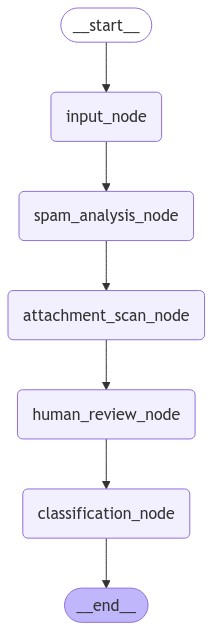

In [23]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))
